In [3]:
# %%
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandapower.networks as nw
from scipy import stats
import pandapower.plotting as plot
import xlsxwriter as xw
import csv
from math import ceil

import pandapower as pp
from pandapower.networks import case1354pegase
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.figsize'] = (4, 3)
plt.rcParams['font.size'] = 10
plt.rcParams['font.family'] = 'Times New Roman'

# %%
# Run the case file and check if there is any error
net = nw.case1354pegase()
# Set the sgen NOT in service
net.sgen.in_service = False
## maximum line and transformer loading percent determine the convergence
# Set maximum line loading percentage
net.line.max_loading_percent = 10000
# Set transformer loading percent as unlimited
net.trafo.max_loading_percent = 1e20
##get load buses from here and the genrator randomly chose 20 percent to be wind buses 
pp.to_excel(net,"case1354pegase.xlsx")      


pp.rundcopp(net)

# %%
############################################################################################


def read_csv_to_array(filepath):
    array = []
    with open(filepath, newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            array.append(row[0])
    return array

def select_random_values(original_array, percentage):
    num_values_to_select = int(len(original_array) * percentage)
    return random.sample(original_array, num_values_to_select)

def write_array_to_csv(data_array, filepath):
    with open(filepath, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        for item in data_array:
            writer.writerow([item])

def remove_selected_values(original_array, values_to_remove):
    return [item for item in original_array if item not in values_to_remove]

selection_percentage = 0.2

res_array = read_csv_to_array('zones/re_gen_bus.csv')
res_array = [int(value) for value in res_array]
selected_values = select_random_values(res_array, selection_percentage)

write_array_to_csv(selected_values, 'zones/wind_bus.csv')

res_array = remove_selected_values(res_array, selected_values)
write_array_to_csv(res_array, 'zones/thermal_bus.csv')






############################################################################################

# %%
#############################################################################################
# Manually set renewable generator bus (should be bus no., and should be a 1D array)
re_gen_bus = pd.read_csv('zones/re_gen_bus.csv', index_col=0, header=0).to_numpy().reshape((-1))
re_gen_no = np.isin(net.gen.bus.values, re_gen_bus) # Get the element of renewable generators

# Get generator bus no. (slack bus included)
gen_no = np.isin(net.bus.name-1, net.gen.bus)
# Get generator bus no. (including renewable, thermal and slack buses)
# slack_gen_no = np.isin(net.bus.name-1, net.gen.bus)

# Get load buses no.
load_no = np.isin(net.bus.name-1, net.load.bus)

# Get buses which are both load and gen
load_gen_bus = net.load.bus[np.isin(net.load.bus, net.gen.bus)]
#############################################################################################


# %%
# The array to store 'p_mw' of net.res_bus
bus_features = ['p_mw']
p_bus_list = np.empty((net.bus.shape[0], len(bus_features)))

# The arrry to store corresponding results 'net.res_gen.p_mw' & 'net.res_gen.va_degree'
# For the time being, we only consider 'p_mw'
# p_gen_features = ['p_mw', 'va_degree']
gen_features = ['p_mw']
p_gen_list = np.empty((net.gen.shape[0]*len(gen_features), 1))
p_max_gen_list = np.empty((net.gen.shape[0], 1))

# The array to store p_mw at load buses
p_load_list = np.empty((net.load.shape[0], 1))

# The array to store corresponding results 'net.res.line...' (there are multiple features in line result).
# Only need to keep the following five features in DC OPF.
# For the time being, we only care about 'p_mw'
# pf_line_features = ['p_from_mw', 'i_ka', 'va_from_degree', 'va_to_degree', 'loading_percent']
line_features = ['p_from_mw']
pf_line_list = np.empty((net.line.shape[0]*len(line_features), 1))
lp_line_list = np.empty((net.line.shape[0], 1))

# The array to store slack bus 'max_p_mw'
p_slack_max_list = []

# Global features
shedding_reserve_list = []
total_cost_list = []

# %%


# %%
def zoneMaker(data_array, filepath, amount):
    with open(filepath, mode='w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        for item in data_array[:amount]:  # Only write the specified amount
            writer.writerow([item])
            
def combine_arrays(array1, array2):
    return np.concatenate((array1, array2))

loadBus_Arr = read_csv_to_array('zones/load_bus.csv')
windBus_Arr = read_csv_to_array('zones/wind_bus.csv')
thermalBus_Arr = read_csv_to_array('zones/thermal_bus.csv')
all_bus_Arr = combine_arrays(loadBus_Arr, windBus_Arr)
all_bus_Arr = combine_arrays(all_bus_Arr, thermalBus_Arr)
all_RES_bus_Arr = combine_arrays(windBus_Arr, thermalBus_Arr)
num_zones = 8

loadBus_val= ceil(len(loadBus_Arr)/num_zones)
windBus_val= ceil(len(windBus_Arr)/num_zones)
thermalBus_val= ceil(len(thermalBus_Arr)/num_zones)




for i in range(num_zones):

    zoneMaker(all_bus_Arr, f'zones/zone{i+1}_bus.csv', len(all_bus_Arr))
    zoneMaker(all_RES_bus_Arr, f'zones/zone{i+1}_gen_bus.csv', len(all_RES_bus_Arr))
    zoneMaker(loadBus_Arr, f'zones/zone{i+1}_load_bus.csv', loadBus_val)
    
    
    zoneMaker(windBus_Arr, f'zones/zone{i+1}_wind_bus.csv', windBus_val)
    
    zoneMaker(thermalBus_Arr, f'zones/zone{i+1}_thermal_bus.csv', thermalBus_val)


# Load gen/load bus in individual zone (globals() dynamicly create variables)

for i in range(1, num_zones):
    # Load bus
    var_name = f'zone{i}_load_bus'
    globals()[var_name] = pd.read_csv(f'zones/{var_name}.csv', index_col=None, header=None).to_numpy() 
    var_name = f'zone{i}_load_bidx'
    globals()[var_name] = np.isin(net.load.bus, globals()[f'zone{i}_load_bus'])

    # Gen bus
    var_name = f'zone{i}_gen_bus'
    globals()[var_name] = pd.read_csv(f'zones/{var_name}.csv', index_col=None, header=None).to_numpy() 
    var_name = f'zone{i}_gen_bidx'
    globals()[var_name] = np.isin(net.gen.bus, globals()[f'zone{i}_gen_bus'])

    # Wind bus
    var_name = f'zone{i}_wind_bus'
    globals()[var_name] = pd.read_csv(f'zones/{var_name}.csv', index_col=None, header=None).to_numpy() 
    var_name = f'zone{i}_wind_bidx'
    globals()[var_name] = np.isin(net.gen.bus, globals()[f'zone{i}_wind_bus'])






/opt/homebrew/lib/python3.11/site-packages/pandapower/io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
/opt/homebrew/lib/python3.11/site-packages/pandapower/io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
/opt/homebrew/lib/python3.11/site-packages/pandapower/io_utils.py:509: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(self.obj, precise_float=True, convert_axes=False, **self.d)
/opt/homebrew/lib/python3.11/site-packag

In [4]:

# Set number of RVs (Only used for generating plots, DOES NOT HAVE ANY EFFECT ON THE SIMULATION)
num_rv = 1000

# Set distribution parameters
mu = np.array([50, 75, 100, 48, 81, 98, 52, 83])
std = np.array([15, 20, 15, 12, 21, 15, 13, 20])
rv_min = np.array([10, 25, 60, 9, 23, 60, 7, 21])
rv_max = np.array([90, 125, 140, 87, 139, 136, 97, 145])

# Generate distributions and RVs
for i in range(1, num_zones+1):
    # Left / right truncation in terms of standard deviation
    a = (rv_min[i-1] - mu[i-1]) / std[i-1]
    b = (rv_max[i-1] - mu[i-1]) / std[i-1]

    var_name = f'lx{i}'
    globals()[var_name] = np.linspace(rv_min[i-1], rv_max[i-1], num_rv)

    # Generate distributions
    var_name = f'tn{i}'
    globals()[var_name] = stats.truncnorm(loc=mu[i-1], scale=std[i-1], a=a, b=b)

    # Generate random variables and corresponding PDF
    var_name = f'tn_rv{i}'
    globals()[var_name] = globals()[f'tn{i}'].rvs(size=num_rv)
    var_name = f'tn_pdf{i}'
    globals()[var_name] = globals()[f'tn{i}'].pdf(x=globals()[f'lx{i}'])

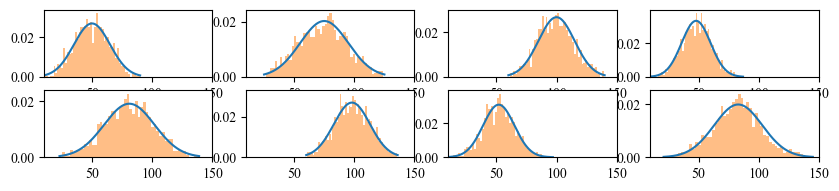

In [5]:
## Plot load RVs
fig = plt.figure(figsize=(10, 4))

for i in range(1, num_zones+1):
    ax = fig.add_subplot(4, 4, i)
    ax.plot(globals()[f'lx{i}'], globals()[f'tn_pdf{i}'])
    _, _, _ = ax.hist(globals()[f'tn_rv{i}'], bins=50, density=True, alpha=0.5)
    ax.set_xlim(10, 150)

plt.show()
plt.close('all')

In [6]:
## Define func wind speed --> wind energy
def windSpeedToPower(w):
    """
        input:
            w: wind speed (m/s), ndarray
        output:
            P: wind power (MW), ndarray
    """
    # Check the input type
    if type(w) != np.ndarray:
        raise TypeError("'w' should be 'numpy.ndarray'.")
    # Set maximum allowed wind power generation
    Pr = 100.
    # No wind power if w < wi
    wi = 1.
    # Wind speed that reaches maximum allowed wind power capacity
    wr = 15.
    # Convert wind speed to wind power
    P = Pr*(w**3 - wi**3)/(wr**3 - wi**3)
    # Get index of wind speed less than wi
    left_index = (w < wi)
    P[left_index] = 0.
    # Get index of wind speed bigger than wi
    right_index = (w > wr)
    P[right_index] = Pr

    return P

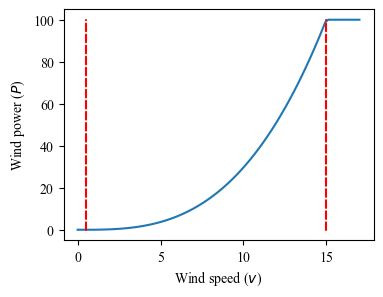

In [7]:
w = np.linspace(0, 17, 100)
P = windSpeedToPower(w)
plt.plot(w, P)
plt.vlines(x=0.5, ymin=0, ymax = 100, color='red', linestyles='dashed')
plt.vlines(x=15., ymin=0, ymax = 100, color='red', linestyles='dashed')
plt.xlabel('Wind speed ($v$)')
plt.ylabel('Wind power ($P$)')
plt.show()
plt.close('all')

In [8]:
# Set parameters
loc = 0.
scale = np.array([8, 8.2, 12, 8.1, 7.9, 7.7, 8, 8.3, 7.8, 8.1, 12.5, 8.5, 7.5, 7.7, 8, 8.3])
shape = np.array([2, 1.8, 8, 1.9, 2.1, 1.9, 2.1, 2.0, 1.8, 1.8, 8.1, 2.2, 1.8, 2.0, 2.0, 2.5])

# Generate distributions and RVs
lx = np.linspace(0, 30, num_rv)
for i in range(1, num_zones+1):
    # Generate distributions
    var_name = f'twb{i}'
    globals()[var_name] = stats.weibull_min(loc=loc, c=shape[i-1], scale=scale[i-1])

    # Generate random variables and corresponding PDF
    var_name = f'twb_rv{i}'
    globals()[var_name] = globals()[f'twb{i}'].rvs(size=num_rv)
    var_name = f'twb_pdf{i}'
    globals()[var_name] = globals()[f'twb{i}'].pdf(x=lx)

    # Conver wind speed to wind power
    var_name = f'wind_power{i}'
    globals()[var_name] = windSpeedToPower(globals()[f'twb_rv{i}'])

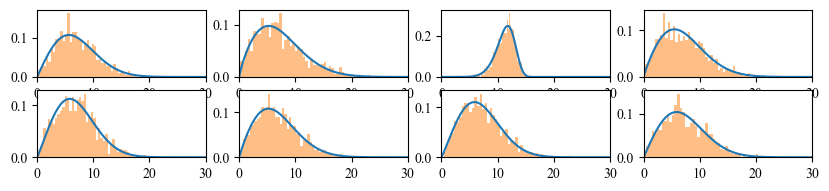

In [9]:
## Plot wind speed RVs
fig = plt.figure(figsize=(10, 4))

for i in range(1, num_zones+1):
    ax = fig.add_subplot(4, 4, i)
    ax.plot(lx, globals()[f'twb_pdf{i}'])
    _, _, _ = ax.hist(globals()[f'twb_rv{i}'], bins=50, density=True, alpha=0.5)
    ax.set_xlim(0, 30)

plt.show()
plt.close('all')

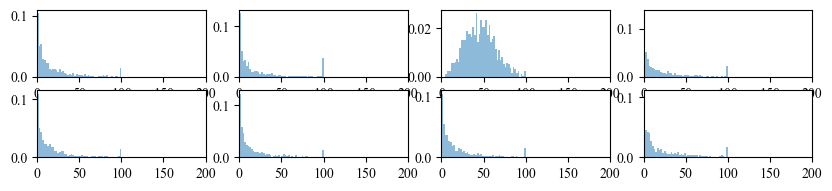

In [10]:
## Plot wind power
fig = plt.figure(figsize=(10, 4))

for i in range(1, num_zones+1):
    ax = fig.add_subplot(4, 4, i)
    _, _, _ = ax.hist(globals()[f'wind_power{i}'], bins=50, density=True, alpha=0.5)
    ax.set_xlim(0, 200)

plt.show()
plt.close('all')

In [13]:
## Read correlation matrix
corr_matrix = pd.read_csv('misc/corr_mat.csv', index_col=None, header=None).to_numpy()

## Read load /wind proportions
for i in range(1, num_zones+1):
    var_name = f'zone{i}_load_proportion'
    globals()[var_name] = pd.read_csv(f'zones/zone{i}_load_proportion.csv', 
                                      index_col=None, header=None).to_numpy().reshape((-1))
    
    var_name = f'zone{i}_wind_proportion'   
    globals()[var_name] = pd.read_csv(f'zones/zone{i}_wind_proportion.csv', 
                                      index_col=None, header=None).to_numpy().reshape((-1))

FileNotFoundError: [Errno 2] No such file or directory: 'zones/zone1_load_proportion.csv'